In [1]:
import torch
import copy
import numpy as np
import matplotlib.pyplot as plt

from transformers import AutoModelForCausalLM
from peft import LoraConfig, get_peft_model

device = "cuda" if torch.cuda.is_available() else "cpu"

MODEL_ID = "distilgpt2"
SEQ_LEN = 64
LR_FULL = 1e-4
LR_LORA = 1e-3


2026-02-06 13:43:54.767797: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770385434.959356      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770385435.011374      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770385435.472992      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770385435.473030      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770385435.473032      55 computation_placer.cc:177] computation placer alr

In [2]:
base_model = AutoModelForCausalLM.from_pretrained(MODEL_ID).to(device)

initial_params = {
    name: p.detach().clone()
    for name, p in base_model.named_parameters()
    if "c_attn.weight" in name
}

print("Tracked layers:", list(initial_params.keys()))


config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Tracked layers: ['transformer.h.0.attn.c_attn.weight', 'transformer.h.1.attn.c_attn.weight', 'transformer.h.2.attn.c_attn.weight', 'transformer.h.3.attn.c_attn.weight', 'transformer.h.4.attn.c_attn.weight', 'transformer.h.5.attn.c_attn.weight']


In [3]:
full_model = copy.deepcopy(base_model)

full_optimizer = torch.optim.AdamW(
    full_model.parameters(),
    lr=LR_FULL
)


In [4]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["c_attn"],
    task_type="CAUSAL_LM"
)

lora_model = get_peft_model(
    copy.deepcopy(base_model),
    lora_config
).to(device)

lora_optimizer = torch.optim.AdamW(
    lora_model.parameters(),
    lr=LR_LORA
)


/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/layer.py:2174: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [5]:
torch.manual_seed(42)

input_ids = torch.randint(
    0, 50257,
    (1, SEQ_LEN)
).to(device)


In [6]:
full_model.train()

loss_full = full_model(
    input_ids,
    labels=input_ids
).loss

loss_full.backward()

full_optimizer.step()
full_optimizer.zero_grad()




`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


In [7]:
lora_model.train()

loss_lora = lora_model(
    input_ids,
    labels=input_ids
).loss

loss_lora.backward()

lora_optimizer.step()
lora_optimizer.zero_grad()



In [8]:
lora_merged = lora_model.merge_and_unload()


In [9]:
from torch.nn.functional import cosine_similarity

similarities = []
layer_names = []

for name, init_w in initial_params.items():

    full_w = dict(full_model.named_parameters())[name]
    lora_w = dict(lora_merged.named_parameters())[name]

    delta_full = full_w.detach() - init_w
    delta_lora = lora_w.detach() - init_w

    v_full = delta_full.view(-1)
    v_lora = delta_lora.view(-1)

    cos = cosine_similarity(
        v_full.unsqueeze(0),
        v_lora.unsqueeze(0)
    ).item()

    similarities.append(cos)
    layer_names.append(name)

    print(f"{name}: {cos:.4f}")


transformer.h.0.attn.c_attn.weight: 0.0195
transformer.h.1.attn.c_attn.weight: 0.0198
transformer.h.2.attn.c_attn.weight: 0.0252
transformer.h.3.attn.c_attn.weight: 0.0231
transformer.h.4.attn.c_attn.weight: 0.0275
transformer.h.5.attn.c_attn.weight: 0.0354


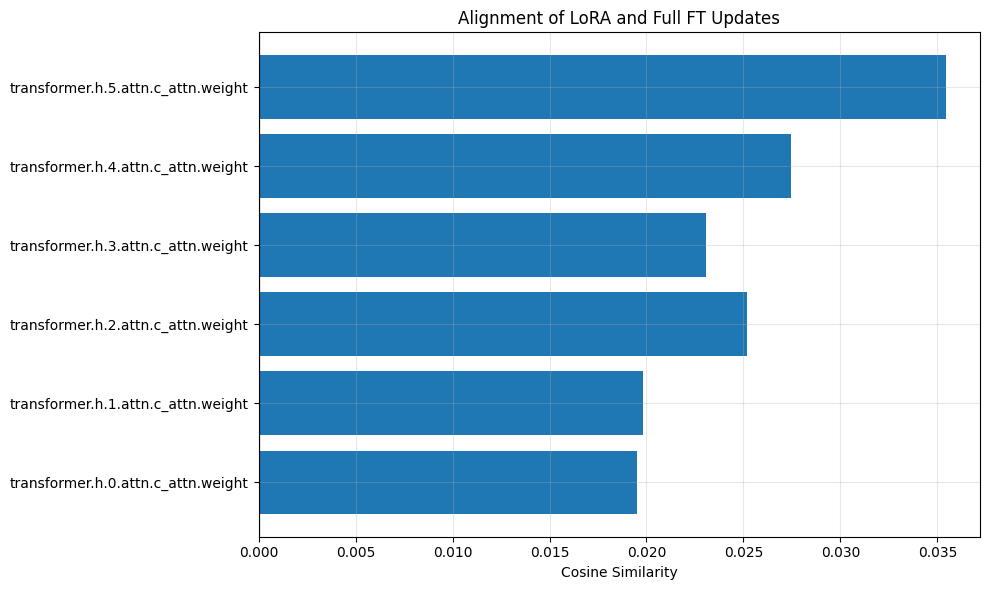

In [10]:
plt.figure(figsize=(10,6))

plt.barh(layer_names, similarities)

plt.xlabel("Cosine Similarity")
plt.title("Alignment of LoRA and Full FT Updates")

plt.axvline(0, color="black", linewidth=0.8)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [12]:
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)


Using device: cuda


In [14]:
from datasets import load_dataset
from transformers import AutoTokenizer
from torch.utils.data import DataLoader

dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")

tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token

def tokenize_fn(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=64
    )

tokenized = dataset.map(
    tokenize_fn,
    batched=True,
    remove_columns=["text"]
)

tokenized.set_format(
    type="torch",
    columns=["input_ids", "attention_mask"]
)

dataloader = DataLoader(
    tokenized,
    batch_size=1,
    shuffle=True
)



README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

Running multi-step alignment test
Step 00 | Alignment = 0.0182
Step 01 | Alignment = 0.0343
Step 02 | Alignment = 0.0476
Step 03 | Alignment = 0.0605
Step 04 | Alignment = 0.0713
Step 05 | Alignment = 0.0800
Step 06 | Alignment = 0.0866
Step 07 | Alignment = 0.0961
Step 08 | Alignment = 0.1063
Step 09 | Alignment = 0.1163
Step 10 | Alignment = 0.1271
Step 11 | Alignment = 0.1378
Step 12 | Alignment = 0.1477
Step 13 | Alignment = 0.1563
Step 14 | Alignment = 0.1637
Step 15 | Alignment = 0.1700
Step 16 | Alignment = 0.1748
Step 17 | Alignment = 0.1783
Step 18 | Alignment = 0.1807
Step 19 | Alignment = 0.1822
Step 20 | Alignment = 0.1830
Step 21 | Alignment = 0.1832
Step 22 | Alignment = 0.1839
Step 23 | Alignment = 0.1848
Step 24 | Alignment = 0.1858
Step 25 | Alignment = 0.1869
Step 26 | Alignment = 0.1877
Step 27 | Alignment = 0.1885
Step 28 | Alignment = 0.1893
Step 29 | Alignment = 0.1899
Step 30 | Alignment = 0.1902
Step 31 | Alignment = 0.1903
Step 32 | Alignment = 0.1900
Step 33 |

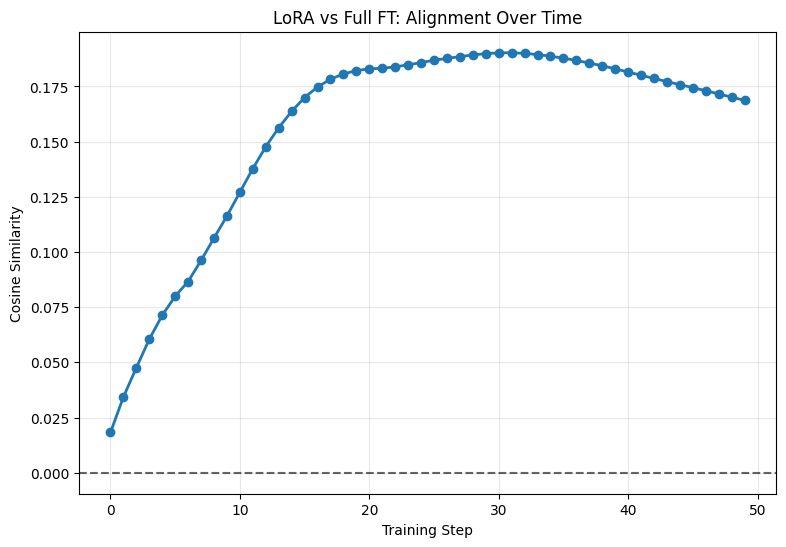

In [17]:
STEPS = 50
LR_FULL = 1e-4
LR_LORA = 1e-3
TARGET_MODULE = "c_attn"

init_weights = {
    n: p.detach().clone()
    for n, p in base_model.named_parameters()
    if TARGET_MODULE in n
}


full_model = copy.deepcopy(base_model).to(DEVICE)

full_optimizer = torch.optim.AdamW(
    full_model.parameters(),
    lr=LR_FULL
)


lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=[TARGET_MODULE],
    task_type="CAUSAL_LM"
)

lora_model = get_peft_model(
    copy.deepcopy(base_model),
    lora_config
).to(DEVICE)

lora_optimizer = torch.optim.AdamW(
    lora_model.parameters(),
    lr=LR_LORA
)


cosine_history = []


print("Running multi-step alignment test")


for step in range(STEPS):

    batch = next(iter(dataloader))

    input_ids = batch["input_ids"].to(DEVICE)

    full_model.train()

    loss_f = full_model(
        input_ids,
        labels=input_ids
    ).loss

    loss_f.backward()

    full_optimizer.step()
    full_optimizer.zero_grad()

    lora_model.train()

    loss_l = lora_model(
        input_ids,
        labels=input_ids
    ).loss

    loss_l.backward()

    lora_optimizer.step()
    lora_optimizer.zero_grad()

    with torch.no_grad():
        merged_lora = copy.deepcopy(lora_model)
        merged_lora = merged_lora.merge_and_unload()

    sims = []

    for name, init_p in init_weights.items():

        full_p = dict(full_model.named_parameters())[name]
        lora_p = dict(merged_lora.named_parameters())[name]

        step_full = full_p.detach() - init_p
        step_lora = lora_p.detach() - init_p

        v1 = step_full.flatten()
        v2 = step_lora.flatten()

        cos = torch.nn.functional.cosine_similarity(
            v1.unsqueeze(0),
            v2.unsqueeze(0)
        )

        sims.append(cos.item())


    avg_sim = sum(sims) / len(sims)
    cosine_history.append(avg_sim)

    print(f"Step {step:02d} | Alignment = {avg_sim:.4f}")


plt.figure(figsize=(9,6))

plt.plot(
    cosine_history,
    marker="o",
    linewidth=2
)

plt.axhline(
    0,
    linestyle="--",
    color="black",
    alpha=0.6
)

plt.xlabel("Training Step")
plt.ylabel("Cosine Similarity")

plt.title("LoRA vs Full FT: Alignment Over Time")

plt.grid(alpha=0.3)

plt.show()
